## Project Traffic Sign Classification

### 1. Load The  German Traffic Sign Dataset, but with the images already resized to 32x32. 

In [1]:
# Load pickled data
import pickle
import tensorflow as tf

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [2]:
# load pickled data
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
X_train.shape

(34799, 32, 32, 3)

In [4]:
y_train.shape

(34799,)

In [5]:
X_valid.shape

(4410, 32, 32, 3)

In [6]:
y_valid.shape

(4410,)

In [7]:
X_test.shape

(12630, 32, 32, 3)

In [8]:
y_test.shape

(12630,)

In [9]:
print('Training data:', X_train.shape, y_train.shape)
print('Validation data:', X_valid.shape, y_valid.shape)
print('Testing data:', X_test.shape, y_test.shape)

Training data: (34799, 32, 32, 3) (34799,)
Validation data: (4410, 32, 32, 3) (4410,)
Testing data: (12630, 32, 32, 3) (12630,)


### Summary the dataset

In [10]:
import numpy as np

# Number of examples
n_train, n_validation, n_test = X_train.shape[0], X_valid.shape[0], X_test.shape[0]

# Shape of Traiffic Sign images
image_shape = X_train[0].shape

# Number of Classes 
n_classes = len(np.unique(np.concatenate((y_train, y_valid, y_test))))

print("Number of training examples = ", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples  = ", n_test)
print("Image data shape  = ", image_shape)
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation examples =  4410
Number of testing examples  =  12630
Image data shape  =  (32, 32, 3)
Number of classes =  43


### Visualizing the German DataSet

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Load the csv file
df = pd.read_csv('signnames.csv')

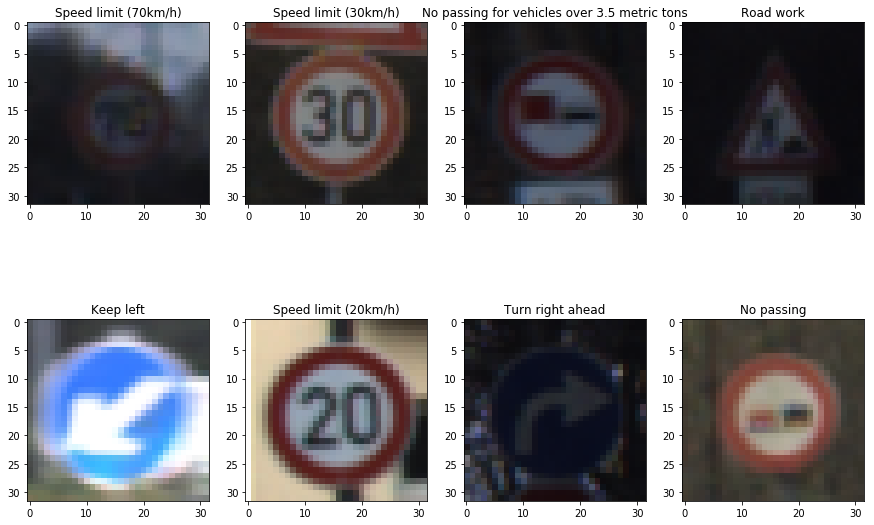

In [12]:
plt.figure(figsize = (15, 10))
index = np.random.randint(0, len(X_train), 8)

for n, i in enumerate(index):
    image = X_train[i].squeeze()
    label = df.loc[y_train[i]]['SignName']
    plt.subplot(240 + n + 1)
    plt.imshow(image)
    plt.title(label)

#### Plot the distribution of Samples in the three datasets

Text(0.5,1,'Test distribution')

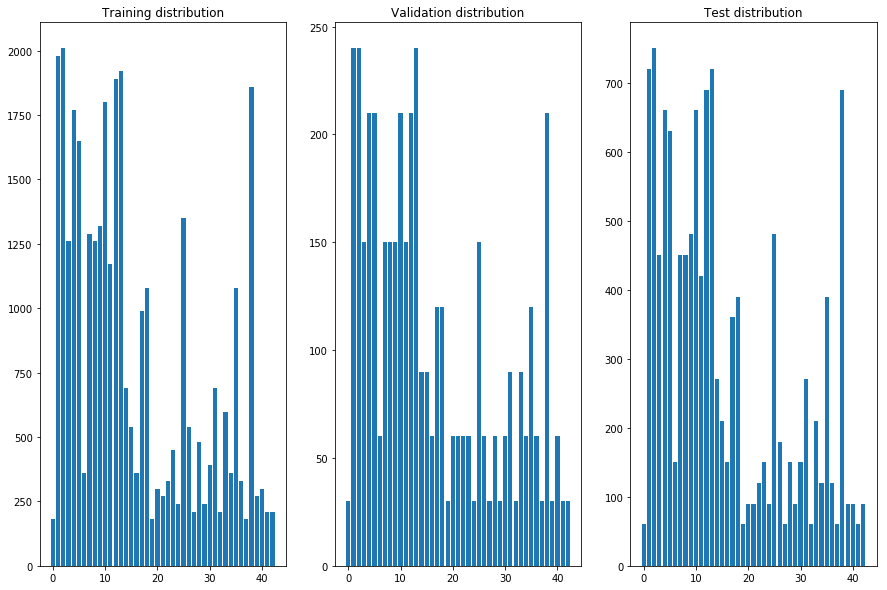

In [13]:
count_train = []
count_valid = []
count_test = []

for i in range(n_classes):
    count_train.append(len(y_train[y_train == i]))
    count_valid.append(len(y_valid[y_valid == i]))
    count_test.append(len(y_test[y_test == i]))
    
plt.figure(figsize = (15, 10))

plt.subplot(131)
plt.bar(np.arange(n_classes), height = count_train)
plt.title('Training distribution')

plt.subplot(132)
plt.bar(np.arange(n_classes), height = count_valid)
plt.title('Validation distribution')

plt.subplot(133)
plt.bar(np.arange(n_classes), height = count_test)
plt.title('Test distribution')

### Design and Test a Model Architecture

#### Model Architecture

In [14]:
from tensorflow.contrib.layers import flatten

num_chanels = 1

def traffic_net(x, keep_prob):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32xnum_chanels. Output = 30x30x16
    conv1_W = tf.Variable(tf.truncated_normal(shape = (3, 3, num_chanels, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding = 'VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. Input = 30x30x16. Output = 28x28x16
    conv2_W = tf.Variable(tf.truncated_normal(shape = (3, 3, 16, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input  = 28x28x16 Output = 14x14x6
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: Convolutional. Output = 12x12x24.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 24), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(24))
    conv3   = tf.nn.conv2d(conv2_pool, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    
    # Layer 4: Convolutional. Output = 10x10x24.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 24), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(24))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4   = tf.nn.relu(conv4)
    
    # Pooling. Input = 10x10x24. Output = 5x5x24.
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Flatten. Input = 5x5x16. Output = 600.
    hidden_layer_0 = flatten(conv4_pool)
    hidden_layer_0 = tf.nn.dropout(hidden_layer_0, keep_prob)
    
    # Fully Connected. Input = 600. Output = 600.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(600, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(hidden_layer_0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.nn.dropout(fc1, keep_prob)
    
    # Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    activation_layers = [conv1, conv2, conv3, conv4]
    
    return logits, activation_layers

### Train, Valid and Test the Model

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, None)

# To gray Scale 
x_gray = tf.image.rgb_to_grayscale(x)

#Normalization
x_norm = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_gray)

one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits, activation_layers = traffic_net(x_norm, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

### Traing the Model

In [17]:
from sklearn.utils import shuffle

EPOCHS = 30
BATCH_SIZE = 128
dropout = 0.8

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    log_loss = []
    log_valid_acc = []
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        train_loss = []
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss_train = sess.run((training_operation, loss), feed_dict = {x: batch_x, y: batch_y, keep_prob:dropout})
            train_loss.append(loss_train)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Epoch {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        log_loss.append(np.mean(train_loss))
        log_valid_acc.append(validation_accuracy)
        
    saver.save(sess, 'model2/trained_model')
    print("Model Saved!")

Training...

Epoch 1 ...
Validation Accuracy = 0.940

Epoch 2 ...
Validation Accuracy = 0.966

Epoch 3 ...
Validation Accuracy = 0.971

Epoch 4 ...
Validation Accuracy = 0.967

Epoch 5 ...
Validation Accuracy = 0.971

Epoch 6 ...
Validation Accuracy = 0.980

Epoch 7 ...
Validation Accuracy = 0.971

Epoch 8 ...
Validation Accuracy = 0.973

Epoch 9 ...
Validation Accuracy = 0.978

Epoch 10 ...
Validation Accuracy = 0.977

Epoch 11 ...
Validation Accuracy = 0.978

Epoch 12 ...
Validation Accuracy = 0.978

Epoch 13 ...
Validation Accuracy = 0.978

Epoch 14 ...
Validation Accuracy = 0.981

Epoch 15 ...
Validation Accuracy = 0.978

Epoch 16 ...
Validation Accuracy = 0.976

Epoch 17 ...
Validation Accuracy = 0.973

Epoch 18 ...
Validation Accuracy = 0.984

Epoch 19 ...
Validation Accuracy = 0.981

Epoch 20 ...
Validation Accuracy = 0.982

Epoch 21 ...
Validation Accuracy = 0.983

Epoch 22 ...
Validation Accuracy = 0.984

Epoch 23 ...
Validation Accuracy = 0.978

Epoch 24 ...
Validation Accura

### Training Curves

In [18]:
def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    
    ax1.plot(time, data1, color = c1)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('exp')
    
    ax2.plot(time, data2, color = c2)
    ax2.set_ylabel('sin')
    
    return ax1, ax2

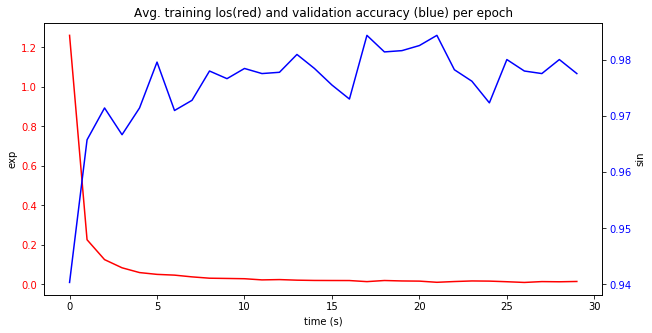

In [19]:
# Create some mock data
t = np.arange(0, EPOCHS)

#create axes
fig, ax = plt.subplots(figsize = (10, 5))
ax1, ax2 = two_scales(ax, t, log_loss, log_valid_acc, 'r', 'b')

# Change color of each axis
def color_y_axis(ax, color):
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.title('Avg. training los(red) and validation accuracy (blue) per epoch')
plt.show()

### Accuracy on testing set

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from model2/trained_model
Test Accuracy = 0.961


### Accuracy on training set

In [21]:
BATCH_SIZE = 128
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from model2/trained_model
Train Accuracy = 1.000


## Test a Model on New Images

#### Load and Output the images

Testing set:  (10, 32, 32, 3)


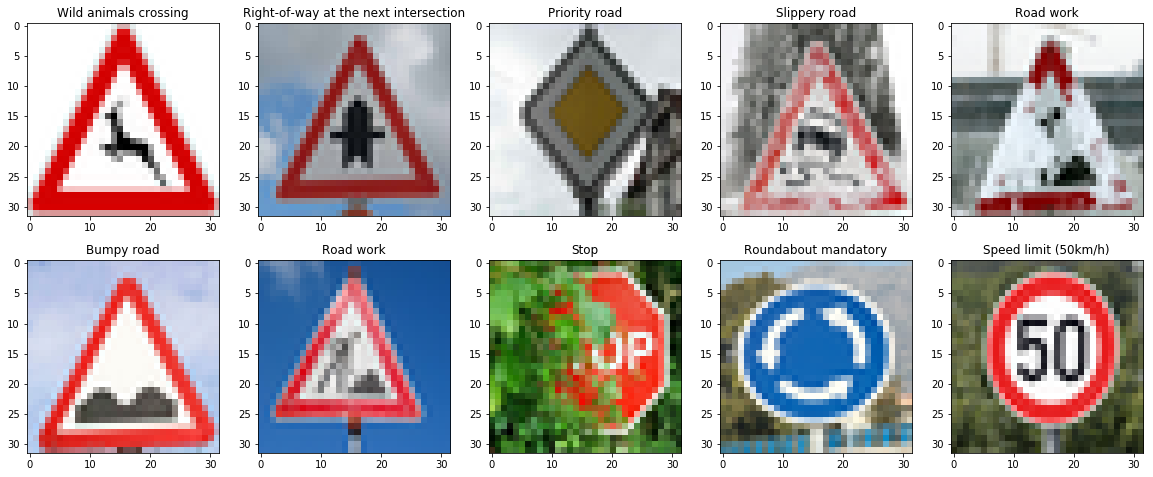

In [22]:
import os
from PIL import Image

df = pd.read_csv('signnames.csv')
new_test_set = []
test_images = os.listdir('examples/')
test_images.sort()
ground_truth = [31, 11, 12, 23, 25, 22, 25, 14, 40, 2]

plt.figure(figsize = (20,8))

for i, file_name in enumerate(test_images):
    img = Image.open('examples/' + file_name)
    img = img.resize((32, 32), Image.ANTIALIAS)
    img = np.asarray(img)
    label = df.loc[ground_truth[i]]['SignName']
    new_test_set.append(img)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    

new_test_set = np.stack(new_test_set)
print('Testing set: ', new_test_set.shape)

#### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from model2/trained_model


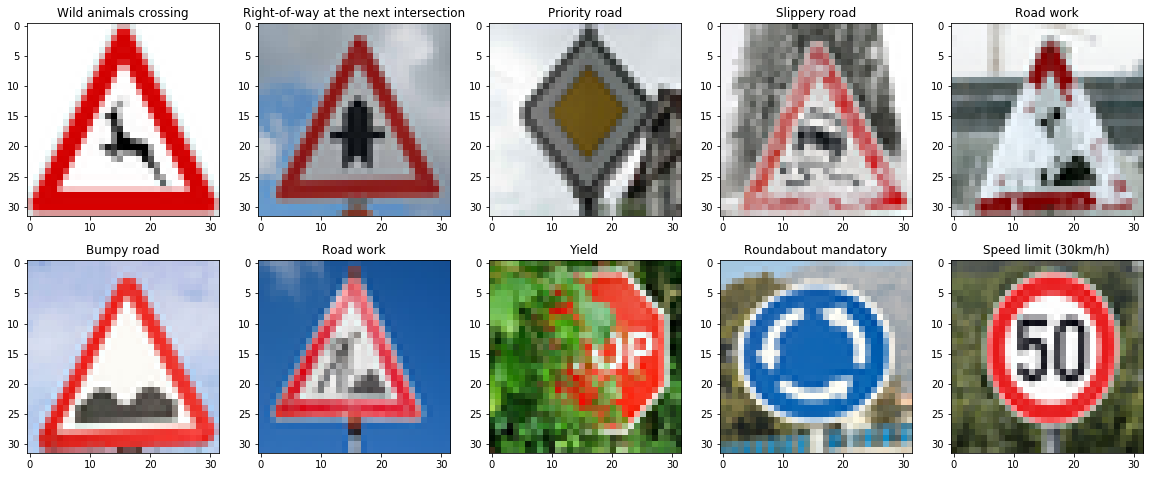

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))
    
    out_logits = sess.run(logits, feed_dict = {x: new_test_set, keep_prob: 1.0})
    
predictions = np.argmax(out_logits, 1)

df = pd.read_csv('signnames.csv')

plt.figure(figsize = (20, 8))
for i in range(new_test_set.shape[0]):
    image = new_test_set[i].squeeze()
    label = df.loc[predictions[i]]['SignName']
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(label)

#### Analyze Performance

In [24]:
accuracy = np.sum(predictions == ground_truth) / new_test_set.shape[0]
print('Accuracy = {0}%'.format(accuracy * 100))

Accuracy = 80.0%


#### Top 5 Softmax Probabilities For Each Image 

In [25]:
k = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))
    
    out_k_logits = sess.run(tf.nn.top_k(logits, k), feed_dict = {x: new_test_set, keep_prob: 1.0})
    
out_k_logits = np.array(out_k_logits)

INFO:tensorflow:Restoring parameters from model2/trained_model


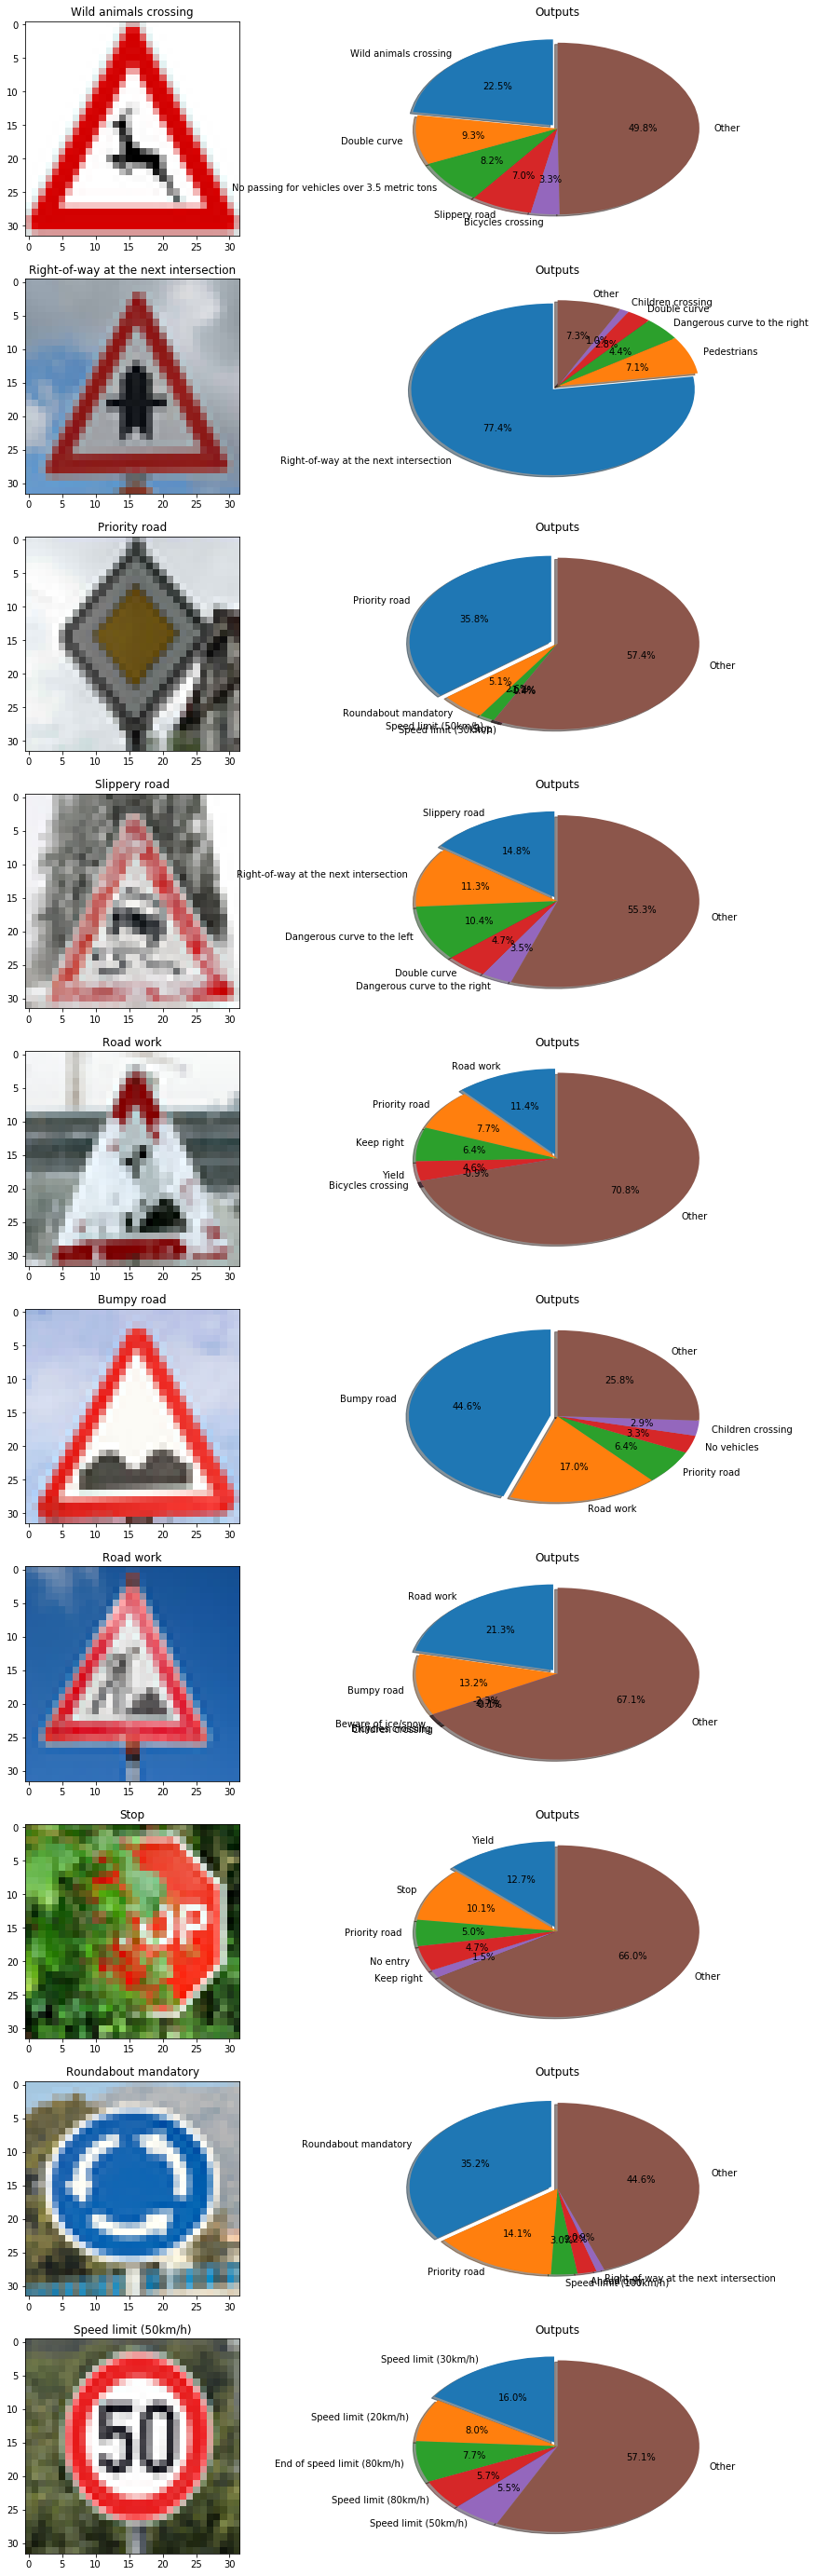

In [26]:
plt.figure(figsize=(15,50))
for i in range(new_test_set.shape[0]):
    labels = []
    for l in out_k_logits[1][i]:
        labels.append(df.loc[l]['SignName'])

    labels.append('Other')
    fracs = out_k_logits[0][i].tolist()
    fracs.append(100-np.sum(fracs))
    explode=[0.05, 0, 0, 0, 0, 0]

    image = new_test_set[i].squeeze()
    real_label = df.loc[ground_truth[i]]['SignName']
    plt.subplot(10,2,2*i+1)
    plt.imshow(image)
    plt.title(real_label)
                 
    plt.subplot(10,2,2*i+2)          
    plt.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Outputs')

#### Plotting activation features

INFO:tensorflow:Restoring parameters from model2/trained_model


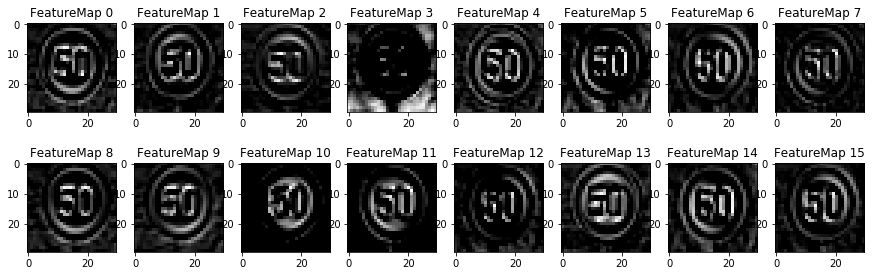

In [27]:
def outputFeatureMap(image_input, tf_activation, sess, activation_min = -1, activation_max = -1, plt_num = 1):
    activation = tf_activation.eval(session = sess, feed_dict = {x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize = (15, 15))
    
    for featuremap in range(featuremaps):
        plt.subplot(6, 8, featuremap + 1)
        plt.title('FeatureMap ' + str(featuremap))
        
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
    
image_input = np.expand_dims(new_test_set[9], 0)
tf_activation = activation_layers[0]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))
    outputFeatureMap(image_input, tf_activation, sess)
                

In [28]:
import cv2
# load new images
new_images_dir = './examples'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir)]
new_test_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_test_images]
# manually annotated labels for these new images
new_targets = [1, 13, 17, 35, 40, 1, 13, 17, 35, 40]

INFO:tensorflow:Restoring parameters from model2/trained_model
Top model predictions for image 3 (Target is 00)
   Prediction = 31 with confidence 1.00
   Prediction = 21 with confidence 0.00
   Prediction = 10 with confidence 0.00
Top model predictions for image 3 (Target is 01)
   Prediction = 11 with confidence 1.00
   Prediction = 27 with confidence 0.00
   Prediction = 20 with confidence 0.00
Top model predictions for image 3 (Target is 02)
   Prediction = 12 with confidence 1.00
   Prediction = 40 with confidence 0.00
   Prediction = 02 with confidence 0.00
Top model predictions for image 3 (Target is 03)
   Prediction = 23 with confidence 0.96
   Prediction = 11 with confidence 0.03
   Prediction = 19 with confidence 0.01
Top model predictions for image 3 (Target is 04)
   Prediction = 25 with confidence 0.97
   Prediction = 12 with confidence 0.02
   Prediction = 38 with confidence 0.01
Top model predictions for image 3 (Target is 05)
   Prediction = 22 with confidence 1.00
   

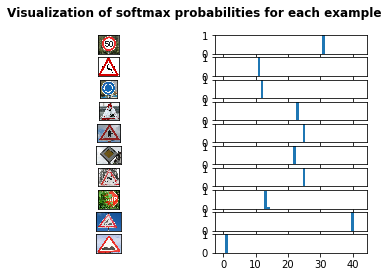

In [29]:
# visualizing softmax probabilities
with tf.Session() as sess:

    # restore saved session
    saver.restore(sess, tf.train.latest_checkpoint('model2/'))

    # certainty of predictions
    #out_logits = sess.run(logits, feed_dict = {x: new_test_set, keep_prob: 1.0})
    
    K = 3
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: new_test_set, keep_prob: 1.})

    # compute softmax probabilities
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: new_test_set, keep_prob: 1.})

# plot softmax probs along with traffic sign examples
n_images = new_test_set.shape[0]
fig, axarray = plt.subplots(n_images, 2)
plt.suptitle('Visualization of softmax probabilities for each example', fontweight='bold')
for r in range(0, n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plt.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plt.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(np.arange(n_classes), softmax_probs[r])
    axarray[r, 1].set_ylim([0, 1])
    
# print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(new_test_images)):
    print('Top model predictions for image {} (Target is {:02d})'.format(K, i, new_targets[i]))
    for k in range(K):
        top_c = top_3[1][i][k]
        print('   Prediction = {:02d} with confidence {:.2f}'.format(top_c, softmax_probs[i][top_c]))


# End of Traffic Sign Classification Project